In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt



Starting training...
Epoch 500/3000, Loss: 1.247124, k: 0.7516, m: 0.8839, x0: 0.0222, v0: -0.1364
Epoch 1000/3000, Loss: 1.247124, k: 0.7516, m: 0.8839, x0: 0.0222, v0: -0.1364
Epoch 1500/3000, Loss: 1.247124, k: 0.7516, m: 0.8839, x0: 0.0222, v0: -0.1364
Epoch 2000/3000, Loss: 1.247124, k: 0.7516, m: 0.8839, x0: 0.0222, v0: -0.1364
Epoch 2500/3000, Loss: 1.247124, k: 0.7516, m: 0.8839, x0: 0.0222, v0: -0.1364
Epoch 3000/3000, Loss: 1.247124, k: 0.7516, m: 0.8839, x0: 0.0222, v0: -0.1364
Training completed.

True spring constant (k): 2.0000
Learned spring constant (k): 0.7516
True mass (m): 0.5000
Learned mass (m): 0.8839
True initial position (x0): 1.0000
Learned initial position (x0): 0.0222
True initial velocity (v0): 0.0000
Learned initial velocity (v0): -0.1364


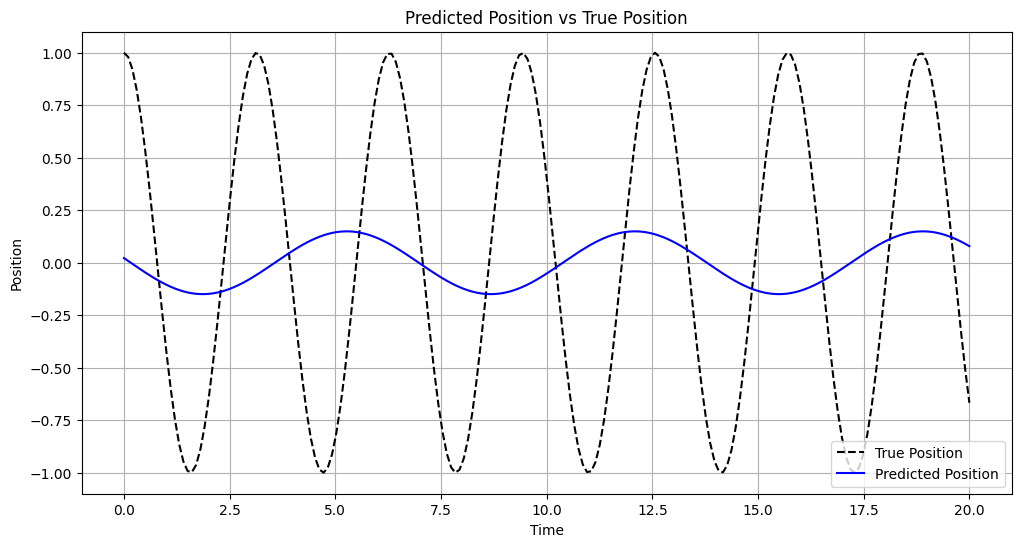

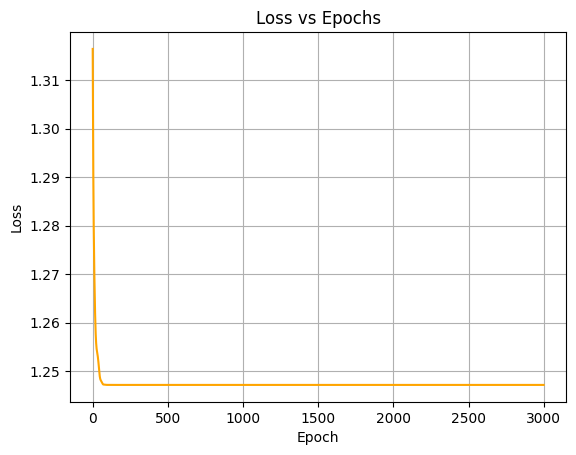

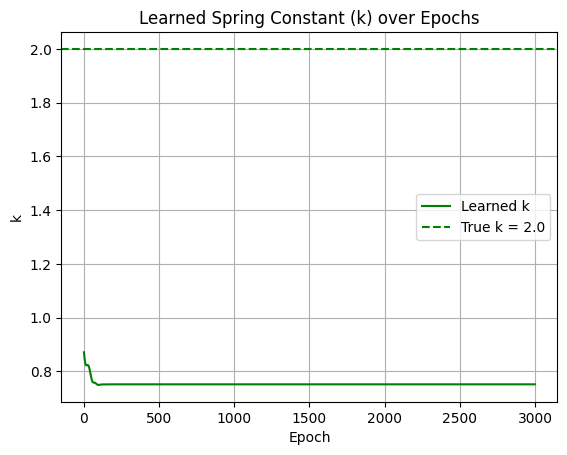

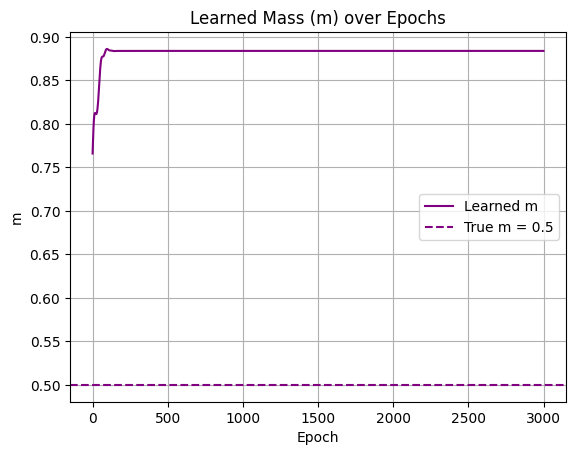

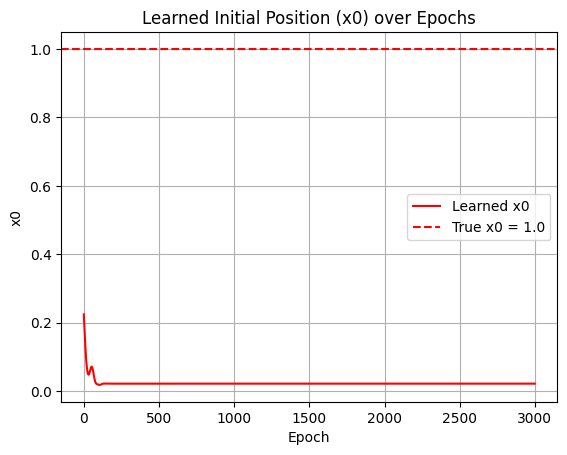

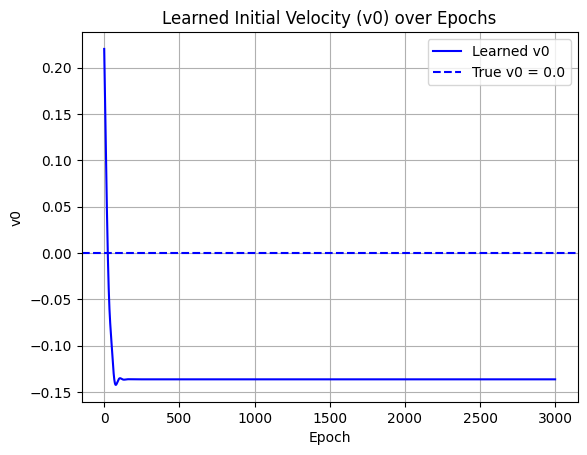

In [9]:
epsilon = 1e-3  # Small positive value to avoid zero

class ODEFunc(nn.Module):
    def __init__(self, hidden_dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2)
        )

        # Raw parameters (can be any real number)
        self.raw_k = nn.Parameter(torch.randn(1))
        self.raw_m = nn.Parameter(torch.randn(1))

        # Initial conditions
        self.x0 = nn.Parameter(torch.randn(1))
        self.v0 = nn.Parameter(torch.randn(1))

    def forward(self, t, y):
        if y.dim() == 1:
            y = y.unsqueeze(0)

        dy = self.net(y)

        x, v = y[:, 0:1], y[:, 1:2]

        # Enforce positivity using softplus function
        k = torch.nn.functional.softplus(self.raw_k) + epsilon
        m = torch.nn.functional.softplus(self.raw_m) + epsilon

        true_dx = v
        true_dv = -(k / m) * x
        true_dy = torch.cat([true_dx, true_dv], dim=1)

        total_dy = true_dy + 0.1 * dy

        return total_dy

    def trajectory(self, t):
        y0 = torch.stack([self.x0, self.v0]).view(1, 2)
        solution = odeint(self, y0, t, method='rk4')
        return solution.squeeze()

    @property
    def k(self):
        return torch.nn.functional.softplus(self.raw_k) + epsilon

    @property
    def m(self):
        return torch.nn.functional.softplus(self.raw_m) + epsilon


    
def generate_dummy_data(t, k, m, x0, v0, noise_std=0.0):
    # Convert inputs to tensors if they're not already
    if not isinstance(t, torch.Tensor):
        t = torch.tensor(t, dtype=torch.float32)
    if not isinstance(k, torch.Tensor):
        k = torch.tensor(k, dtype=torch.float32)
    if not isinstance(m, torch.Tensor):
        m = torch.tensor(m, dtype=torch.float32)
    if not isinstance(x0, torch.Tensor):
        x0 = torch.tensor(x0, dtype=torch.float32)
    if not isinstance(v0, torch.Tensor):
        v0 = torch.tensor(v0, dtype=torch.float32)

    omega = torch.sqrt(k / m)
    x = x0 * torch.cos(omega * t) + (v0 / omega) * torch.sin(omega * t)
    v = -x0 * omega * torch.sin(omega * t) + v0 * torch.cos(omega * t)
    
    if noise_std > 0:
        x += torch.randn_like(x) * noise_std
        v += torch.randn_like(v) * noise_std
    
    return torch.stack([x, v], dim=-1)

def train_neural_ode(func, optimizer, data, t, epochs=250, print_every=500, patience=1000):
    print("Starting training...")
    best_loss = float('inf')
    patience_counter = 0

    # Store loss and learned parameters over time
    losses = []
    k_values = []
    m_values = []
    x0_values = []
    v0_values = []
    
    # Store predictions at certain intervals for visualization
    prediction_intervals = []
    interval_epochs = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        pred = func.trajectory(t)
        loss = torch.mean((pred - data) ** 2)
        loss.backward()
        optimizer.step()
        
        # Record loss and learned parameters
        losses.append(loss.item())
        k_values.append(func.k.item())
        m_values.append(func.m.item())
        x0_values.append(func.x0.item())
        v0_values.append(func.v0.item())
        
        if (epoch + 1) % print_every == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")
            # Store the predictions at this epoch for plotting later
            with torch.no_grad():
                intermediate_preds = func.trajectory(t)
                prediction_intervals.append(intermediate_preds.cpu())
                interval_epochs.append(epoch + 1)
 
        if loss.item() < best_loss:
            best_loss = loss.item()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
    print("Training completed.")

    return pred, losses, k_values, m_values, x0_values, v0_values, prediction_intervals, interval_epochs

# Set random seed for reproducibility
torch.manual_seed(42)

# Generate dummy data
t = torch.linspace(0., 20., 200)
true_k, true_m = 2.0, 0.5
true_x0, true_v0 = 1.0, 0.0
data = generate_dummy_data(t, true_k, true_m, true_x0, true_v0)

# Create and train the Neural ODE
func = ODEFunc(hidden_dim=8)
optimizer = optim.Adam(func.parameters(), lr=0.01)
final_pred, losses, k_values, m_values, x0_values, v0_values, prediction_intervals, interval_epochs = train_neural_ode(
    func, optimizer, data, t, epochs=2500, print_every=500, patience=1000)

# Print learned parameters
print(f"\nTrue spring constant (k): {true_k:.4f}")
print(f"Learned spring constant (k): {func.k.item():.4f}")
print(f"Learned mass (m): {func.m.item():.4f}")
print(f"Learned mass (m): {func.m.item():.4f}")
print(f"True initial position (x0): {true_x0:.4f}")
print(f"Learned initial position (x0): {func.x0.item():.4f}")
print(f"True initial velocity (v0): {true_v0:.4f}")
print(f"Learned initial velocity (v0): {func.v0.item():.4f}")

# =========================
# PLOT IMPROVEMENTS OVER TIME
# =========================
plt.figure(figsize=(12, 8))
plt.plot(t, data[:, 0], label='True Position', linestyle='--', color='black')  # True data

# Plot predictions for each stored interval
for preds, epoch in zip(prediction_intervals, interval_epochs):
    plt.plot(t, preds[:, 0], label=f'Predicted Position (Epoch {epoch})')

plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Improvement of Predictions Over Time')
plt.legend()
plt.grid(True)
plt.show()

# =========================
# FINAL PREDICTIONS vs. TRUE DATA
# =========================
plt.figure(figsize=(12, 8))

# True data and final predictions
plt.subplot(2, 1, 1)
plt.plot(t, data[:, 0], label='True Position', linestyle='--', color='black')
plt.plot(t, final_pred[:, 0].detach(), label='Final Predicted Position', color='blue')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Final Prediction vs True Data')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(data[:, 0], data[:, 1], label='True', linestyle='--', color='black')
plt.plot(final_pred[:, 0].detach(), final_pred[:, 1].detach(), label='Final Predicted', color='blue')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Phase Space Plot: Final Prediction vs True')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =========================
# LOSS vs. EPOCHS
# =========================
plt.figure()
plt.plot(losses, color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.grid(True)
plt.show()

# =========================
# LEARNED PARAMETERS vs. TRUE VALUES
# =========================

# Plot the Learned Spring Constant (k) with true value
plt.figure()
plt.plot(k_values, label='Learned Spring Constant (k)', color='green')
plt.axhline(y=true_k, color='green', linestyle='--', label=f'True k = {true_k}')
plt.xlabel('Epoch')
plt.ylabel('k')
plt.title('Learned Spring Constant (k) over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot the Learned Mass (m) with true value
plt.figure()
plt.plot(m_values, label='Learned Mass (m)', color='purple')
plt.axhline(y=true_m, color='purple', linestyle='--', label=f'True m = {true_m}')
plt.xlabel('Epoch')
plt.ylabel('m')
plt.title('Learned Mass (m) over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot the Learned Initial Position (x0) with true value
plt.figure()
plt.plot(x0_values, label='Learned Initial Position (x0)', color='red')
plt.axhline(y=true_x0, color='red', linestyle='--', label=f'True x0 = {true_x0}')
plt.xlabel('Epoch')
plt.ylabel('x0')
plt.title('Learned Initial Position (x0) over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot the Learned Initial Velocity (v0) with true value
plt.figure()
plt.plot(v0_values, label='Learned Initial Velocity (v0)', color='blue')
plt.axhline(y=true_v0, color='blue', linestyle='--', label=f'True v0 = {true_v0}')
plt.xlabel('Epoch')
plt.ylabel('v0')
plt.title('Learned Initial Velocity (v0) over Epochs')
plt.legend()
plt.grid(True)
plt.show()
